The plot compares precision, recall, and F1 score for each model on the test set, using thresholds selected on the training set

Conclusion:
- Logistic Regression is conservative: when it predicts a match, it is more often correct, but it misses many potential matches.
- The Decision Tree underperforms due to overfitting and instability, even after tuning.
- Random Forest performs best overall, capturing more true matches while maintaining reasonable precision.
- KNN struggles in this high-dimensional, subjective dataset and does not separate matches well.

Overall, Random Forest is the best-performing model in terms of overall predictive performance, as it achieves the highest F1 score on the test set when using thresholds selected on the training data.
However, Logistic Regression remains a strong alternative due to its higher precision and superior interpretability, which may be preferable depending on business priorities.

## 1. Introduction

### 1.1. Import libraries

In [2]:
import pandas as pd
import numpy as np 

# Sklearn modules for data splitting, preprocessing, model building and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# Models to be used for classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict

# Evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### 1.2. Load Dataset

In [3]:
df = pd.read_csv("train.csv")

## 2. Data Preparation

### 2.1. Data Description and Inspection

In [4]:
# Print the shape of the dataframe
df.shape

(1048, 65)

In [5]:
# Print the first few rows of the dataframe
df.head()

,is_dater_male,dater_age,dated_age,age_difference,dater_race,dated_race,are_same_race,same_race_importance_for_dater,same_religion_importance_for_dater,attractiveness_importance_for_dated,...,interests_correlation,expected_satisfaction_of_dater,expected_number_of_likes_of_dater_from_20_people,expected_number_of_dates_for_dater,dater_liked_dated,probability_dated_wants_to_date,already_met_before,dater_wants_to_date,dated_wants_to_date,is_match
0,False,21,27,6,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,35.0,...,0.14,3.0,2,4,7.0,6.0,True,True,False,0
1,False,21,22,1,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,60.0,...,0.54,3.0,2,4,7.0,5.0,True,True,False,0
2,False,21,23,2,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,30.0,...,0.61,3.0,2,4,7.0,6.0,True,True,True,1
3,False,21,24,3,'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',False,2.0,4.0,30.0,...,0.21,3.0,2,4,6.0,6.0,True,True,True,1
4,False,21,25,4,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,50.0,...,0.25,3.0,2,4,6.0,5.0,True,False,True,0


In [6]:
# Print the data types of each column
df.dtypes

is_dater_male                         bool
dater_age                            int64
dated_age                            int64
age_difference                       int64
dater_race                          object
                                    ...   
probability_dated_wants_to_date    float64
already_met_before                    bool
dater_wants_to_date                   bool
dated_wants_to_date                   bool
is_match                             int64
Length: 65, dtype: object

### 2.2. Data Preprocessing and Cleaning 

In [7]:
# Remove rows with missing values
df = df.dropna(subset=["is_match"])

In [8]:
# Change the column names to don't use underscores and to use upper first letters
df.columns = [col.replace('_', ' ').title() for col in df.columns]

In [9]:
# print all the column names
print(df.columns.tolist())

['Is Dater Male', 'Dater Age', 'Dated Age', 'Age Difference', 'Dater Race', 'Dated Race', 'Are Same Race', 'Same Race Importance For Dater', 'Same Religion Importance For Dater', 'Attractiveness Importance For Dated', 'Sincerity Importance For Dated', 'Intelligence Importance For Dated', 'Humor Importance For Dated', 'Ambition Importance For Dated', 'Shared Interests Importance For Dated', 'Attractiveness Score Of Dater From Dated', 'Sincerity Score Of Dater From Dated', 'Intelligence Score Of Dater From Dated', 'Humor Score Of Dater From Dated', 'Ambition Score Of Dater From Dated', 'Shared Interests Score Of Dater From Dated', 'Attractiveness Importance For Dater', 'Sincerity Importance For Dater', 'Intelligence Importance For Dater', 'Humor Importance For Dater', 'Ambition Importance For Dater', 'Shared Interests Importance For Dater', 'Self Reported Attractiveness Of Dater', 'Self Reported Sincerity Of Dater', 'Self Reported Intelligence Of Dater', 'Self Reported Humor Of Dater', '

In [10]:
# Store all column names before making changes
cols_before = set(df.columns)

# Drop unwanted columns (gender, religion, etc.)
df = df.drop(
    columns=[
        "Dated Wants To Date",
        "Dater Wants To Date",
        "Same Race Importance For Dater",
        "Same Religion Importance For Dater"
    ],
    errors="ignore"  # ignore errors if any columns are missing
)

# Drop all columns containing the word 'Race'
race_cols = [col for col in df.columns if "Race" in col]
df = df.drop(columns=race_cols, errors="ignore")

# Compare column sets before and after to see which columns were removed for verification
cols_after = set(df.columns)
removed_cols = cols_before - cols_after

# Print removed columns
print("Removed columns:", removed_cols)

Removed columns: {'Dated Race', 'Same Race Importance For Dater', 'Dater Wants To Date', 'Same Religion Importance For Dater', 'Are Same Race', 'Dater Race', 'Dated Wants To Date'}


In [11]:
# Convert categorical variables to numerical dummy variables using one-hot encoding
df = pd.get_dummies(df, drop_first=True)
df.head()

,Is Dater Male,Dater Age,Dated Age,Age Difference,Attractiveness Importance For Dated,Sincerity Importance For Dated,Intelligence Importance For Dated,Humor Importance For Dated,Ambition Importance For Dated,Shared Interests Importance For Dated,...,Dater Interest In Shopping,Dater Interest In Yoga,Interests Correlation,Expected Satisfaction Of Dater,Expected Number Of Likes Of Dater From 20 People,Expected Number Of Dates For Dater,Dater Liked Dated,Probability Dated Wants To Date,Already Met Before,Is Match
0,False,21,27,6,35.0,20.0,20.0,20.0,0.0,5.0,...,8.0,1.0,0.14,3.0,2,4,7.0,6.0,True,0
1,False,21,22,1,60.0,0.0,0.0,40.0,0.0,0.0,...,8.0,1.0,0.54,3.0,2,4,7.0,5.0,True,0
2,False,21,23,2,30.0,5.0,15.0,40.0,5.0,5.0,...,8.0,1.0,0.61,3.0,2,4,7.0,6.0,True,1
3,False,21,24,3,30.0,10.0,20.0,10.0,10.0,20.0,...,8.0,1.0,0.21,3.0,2,4,6.0,6.0,True,1
4,False,21,25,4,50.0,0.0,30.0,10.0,0.0,10.0,...,8.0,1.0,0.25,3.0,2,4,6.0,5.0,True,0


In [12]:
# Print the shape of the dataframe after cleaning
df.shape

(1048, 58)

In [13]:
# Get summary statistics of the dataframe
df.describe()

,Dater Age,Dated Age,Age Difference,Attractiveness Importance For Dated,Sincerity Importance For Dated,Intelligence Importance For Dated,Humor Importance For Dated,Ambition Importance For Dated,Shared Interests Importance For Dated,Attractiveness Score Of Dater From Dated,...,Dater Interest In Music,Dater Interest In Shopping,Dater Interest In Yoga,Interests Correlation,Expected Satisfaction Of Dater,Expected Number Of Likes Of Dater From 20 People,Expected Number Of Dates For Dater,Dater Liked Dated,Probability Dated Wants To Date,Is Match
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,...,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,25.005725,24.818702,3.032443,23.728235,16.971021,22.255887,17.325029,9.725792,10.333626,6.211355,...,7.710878,5.511450,4.133588,0.154990,5.378817,5.760496,2.844466,6.218034,4.978053,0.177481
std,3.270365,3.180581,2.427732,12.660571,7.450629,7.352106,6.666005,7.073420,6.763784,1.964935,...,1.899931,2.597821,2.696578,0.335816,1.630245,4.954703,2.370152,1.858517,2.269876,0.382258
min,18.000000,18.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,-0.630000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,22.000000,1.000000,15.000000,10.000000,20.000000,10.832500,5.000000,5.000000,5.000000,...,7.000000,4.000000,2.000000,-0.110000,5.000000,2.000000,1.000000,5.000000,3.000000,0.000000
50%,25.000000,25.000000,2.000000,20.000000,18.000000,20.000000,18.180000,10.000000,10.000000,6.000000,...,8.000000,5.000000,3.000000,0.150000,5.000000,4.000000,2.000000,6.000000,5.000000,0.000000
75%,27.000000,27.000000,4.000000,30.000000,20.000000,25.000000,20.000000,15.000000,15.000000,8.000000,...,9.000000,8.000000,7.000000,0.420000,7.000000,8.000000,4.000000,7.000000,7.000000,0.000000
max,35.000000,35.000000,14.000000,100.000000,40.000000,50.000000,40.000000,53.000000,30.000000,10.000000,...,10.000000,10.000000,10.000000,0.900000,9.000000,20.000000,10.000000,10.000000,10.000000,1.000000


### 2.3. Split Features and Target Variable

In [14]:
# Split the data into features and target variable
# "Is Match" is the target variable and is binary (0 or 1) indicating if there was a match or not
X = df.drop("Is Match", axis=1)
y = df["Is Match"]

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20, # the dataset is small, so use 20% for testing
    stratify=y,
    random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Define K-fold cross-validation on the training data
# CV means cross-validation
# This 'cv' object will be used later when training/evaluating models
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

Train: 838, Test: 210


## 3. Threshold Optimization

### 3.1. Helper Functions

In [15]:
def find_best_threshold_f1(y_true, y_proba, n_grid=501):
    """
    Find threshold that maximizes F1.
    Returns: (best_threshold, best_f1)
    """
    thresholds = np.linspace(0, 1, n_grid)
    f1s = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1s.append(f1_score(y_true, y_pred, zero_division=0))
    best_idx = int(np.argmax(f1s))
    return float(thresholds[best_idx]), float(f1s[best_idx])


def evaluate_at_threshold(y_true, y_proba, threshold):
    """
    Compute metrics + confusion matrix at a given threshold.
    Returns dict.
    """
    y_pred = (y_proba >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    return {
        "Threshold (train-chosen)": float(threshold),
        "Test_Accuracy": float(accuracy_score(y_true, y_pred)),
        "Test_Precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "Test_Recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "Test_F1": float(f1_score(y_true, y_pred, zero_division=0)),
        "TP": int(tp),
        "FP": int(fp),
        "TN": int(tn),
        "FN": int(fn),
    }


def tune_threshold_evaluate(
    name,
    estimator,
    param_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    cv,
    scoring_dict,
    refit_metric="f1",
    n_threshold_grid=501
):
    """
    1) GridSearchCV on training set
    2) Out-of-fold probabilities on training set (cross_val_predict)
    3) Choose threshold that maximizes F1 on training OOF
    4) Fit best estimator on full training set
    5) Evaluate on test set using train-chosen threshold

    Returns: (result_row_dict, best_estimator, test_probabilities)
    """

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring_dict,
        refit=refit_metric,
        n_jobs=-1,
        return_train_score=True
    )

    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_

    # Out-of-fold predicted probabilities on training
    y_proba_oof = cross_val_predict(
        best_est,
        X_train,
        y_train,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]

    best_thr, best_oof_f1 = find_best_threshold_f1(y_train, y_proba_oof, n_grid=n_threshold_grid)

    # Fit on full training
    best_est.fit(X_train, y_train)

    # Predict probabilities on test
    y_proba_test = best_est.predict_proba(X_test)[:, 1]

    # Evaluate at chosen threshold
    row = evaluate_at_threshold(y_test, y_proba_test, best_thr)
    row["Model"] = name
    row["Best OOF F1 (train)"] = best_oof_f1
    row["Best params"] = grid.best_params_

    return row, best_est, y_proba_test

#### 3.1.2 Scoring Dictionary

In [16]:
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision"
}

### 3.2. Logistic Regression

In [17]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000))
])

lr_param_grid = {
    "log_reg__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "log_reg__penalty": ["l1", "l2"],
    "log_reg__solver": ["liblinear", "saga"],
    "log_reg__class_weight": [None, "balanced"],
}

lr_row, lr_best, lr_proba_test = tune_threshold_evaluate(
    name="Logistic Regression",
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    cv=cv,
    scoring_dict=scoring,
    refit_metric="f1"
)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_

### 3.3. Decision Tree

In [18]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

dt_row, dt_best, dt_proba_test = tune_threshold_evaluate(
    name="Decision Tree",
    estimator=dt_model,
    param_grid=dt_param_grid,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    cv=cv,
    scoring_dict=scoring,
    refit_metric="f1"
)

### 3.4. Random Forest

In [19]:
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True]
}

rf_row, rf_best, rf_proba_test = tune_threshold_evaluate(
    name="Random Forest",
    estimator=rf_model,
    param_grid=rf_param_grid,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    cv=cv,
    scoring_dict=scoring,
    refit_metric="f1"
)


### 3.5. KNN

In [20]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "scaler": [StandardScaler(), RobustScaler(), "passthrough"],
    "knn__n_neighbors": [1, 2, 3, 6, 9, 12, 15, 19, 24, 48, 96],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

knn_row, knn_best, knn_proba_test = tune_threshold_evaluate(
    name="KNN",
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    cv=cv,
    scoring_dict=scoring,
    refit_metric="f1"
)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_

### 3.6. Summary of Results

In [21]:
final_results = pd.DataFrame([lr_row, dt_row, rf_row, knn_row]).set_index("Model")
display(final_results[[
    "Threshold (train-chosen)",
    "Best OOF F1 (train)",
    "Test_Accuracy",
    "Test_Precision",
    "Test_Recall",
    "Test_F1",
    "TP", "FP", "TN", "FN"
]].round(4))

,Threshold (train-chosen),Best OOF F1 (train),Test_Accuracy,Test_Precision,Test_Recall,Test_F1,TP,FP,TN,FN
Model,,,,,,,,,,
Logistic Regression,0.710,0.5673,0.8429,0.5714,0.4324,0.4923,16,12,161,21
Decision Tree,0.456,0.4943,0.7810,0.3448,0.2703,0.3030,10,19,154,27
Random Forest,0.274,0.5951,0.7952,0.4423,0.6216,0.5169,23,29,144,14
KNN,0.002,0.3771,0.7952,0.4062,0.3514,0.3768,13,19,154,24


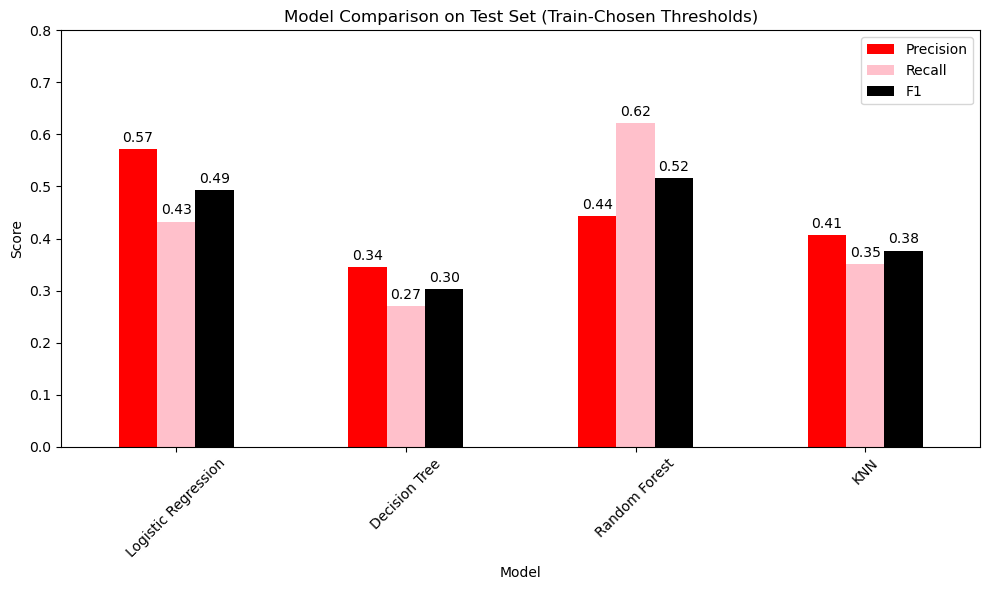

Exception ignored in: <function ResourceTracker.__del__ at 0x1198a5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103b39bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106a1dbc0>
Traceback (most recent call last

In [25]:
import matplotlib.pyplot as plt

# --- Bar chart: Precision / Recall / F1
plot_df = final_results[["Test_Precision", "Test_Recall", "Test_F1"]].copy()
plot_df.rename(columns={
    "Test_Precision": "Precision",
    "Test_Recall": "Recall",
    "Test_F1": "F1"
}, inplace=True)

# Define colors in the same order as columns
colors = ["red", "pink", "black"]

ax = plot_df.plot(
    kind="bar",
    figsize=(10, 6),
    color=colors
)

plt.ylabel("Score")
plt.title("Model Comparison on Test Set (Train-Chosen Thresholds)")
plt.xticks(rotation=45)
plt.ylim(0, 0.8)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

plt.tight_layout()
plt.show()